In [1]:
!pip install mplcyberpunk

In [2]:
import os
import random
import pathlib

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

plt.style.use('cyberpunk')

import warnings
warnings.filterwarnings('ignore')

In [3]:
image_dir = '/kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images'

In [4]:
def get_image_paths(image_dir):
    image_paths = []

    for cls in os.listdir(image_dir):
        img_dir_cls = os.path.join(image_dir, cls)
        for img in os.listdir(img_dir_cls):
            image_paths.append(os.path.join(img_dir_cls, img))
    
    return image_paths

image_paths = get_image_paths(image_dir)

valid_len = int(len(image_paths) * 0.2)
train_len = int(len(image_paths) - valid_len)
test_len = int(len(image_paths) - 100)

random.shuffle(image_paths)

train_paths = image_paths[:train_len]
valid_paths = image_paths[train_len:test_len]
test_paths = image_paths[test_len:]

In [5]:
len(train_paths), len(valid_paths), len(test_paths)

(11121, 2680, 100)

In [6]:
def find_classes(image_dir):
    class_names = os.listdir(image_dir)
    idx_classes = {}
    classes_idx = {}

    for idx, cls in enumerate(class_names):
        idx_classes[idx] = cls
        classes_idx[cls] = idx

    return idx_classes, classes_idx

In [7]:
class ImageDatset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.image_dir = pathlib.Path(image_paths[0]).parent.parent
        self.idx_classes, self.classes_idx = find_classes(self.image_dir)
        self.transform = transform

    def load_image(self, idx):
        return Image.open(self.image_paths[idx])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        class_name = pathlib.Path(self.image_paths[idx]).parent.name
        class_idx = self.classes_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, class_idx

In [8]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [9]:
train_ds = ImageDatset(
    image_paths=train_paths,
    transform=train_transforms
)

valid_ds = ImageDatset(
    image_paths=valid_paths,
    transform=test_transforms
)

test_ds = ImageDatset(
    image_paths=test_paths,
    transform=test_transforms
)

In [10]:
train_dl = DataLoader(
    dataset=train_ds,
    batch_size=64,
    shuffle=True
)

valid_dl = DataLoader(
    dataset=valid_ds,
    batch_size=64,
    shuffle=True
)

test_dl = DataLoader(
    dataset=test_ds,
    batch_size=64,
    shuffle=False
)

dls = {
    'train' : train_dl,
    'valid' : valid_dl,
    'test' : test_dl
}

In [11]:
resnet101model = models.resnet101(pretrained=True)
num_features = resnet101model.fc.in_features
resnet101model.fc = nn.Linear(num_features, 6)

resnet101model

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 214MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential()
        
        self.model.append(nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=0))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(128))
        self.model.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        self.model.append(nn.Dropout(p=0.5))

        self.model.append(nn.Conv2d(128, 256, kernel_size=5, stride=3, padding=0))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(256))
        self.model.append(nn.MaxPool2d(kernel_size=5, stride=3, padding=0))
        self.model.append(nn.Dropout(p=0.5))

        self.model.append(nn.Conv2d(256, 512, kernel_size=5, stride=5, padding=0))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(512))
        self.model.append(nn.Dropout(p=0.5))

        self.model.append(nn.AdaptiveAvgPool2d(1))
        self.model.append(nn.Flatten())
        self.model.append(nn.ReLU())
        self.model.append(nn.Dropout(p=0.5))
        self.model.append(nn.Linear(512, num_classes))

    def forward(self, x):
        return self.model(x)
    
custom_model = CustomModel(num_classes=len(train_ds.classes_idx))

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

In [14]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    train_running_loss = 0.0
    train_correct_predictions = 0
    total_samples = 0

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        train_correct_predictions += torch.sum(preds == labels.data)
        total_samples += images.size(0)

    train_epoch_loss = train_running_loss / total_samples
    train_epoch_acc = train_correct_predictions.double() / total_samples

    return train_epoch_loss, train_epoch_acc

def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            val_correct_predictions += torch.sum(preds == labels)
            total_samples += images.size(0)

    val_epoch_loss = val_running_loss / total_samples
    val_epoch_acc = val_correct_predictions.double() / total_samples

    return val_epoch_loss, val_epoch_acc

    
def training_loop(model, dataloaders, optimizer, loss_fn, epochs, device):
    model.to(device)
    metrics = {'Train Loss' : [], 'Valid Loss' : [], 'Train Accuracy' : [], 'Valid Accuracy' : []}
    
    for epoch in range(epochs):
        print(f'='*25)
        print(f'Epoch:{epoch}')

        train_loss, train_acc = train_one_epoch(
            model=model, 
            dataloader=dataloaders['train'],
            optimizer=optimizer,
            loss_fn=loss_fn,
            device=device
        )
        print(f'Train Loss:{train_loss}, Train Accuracy:{train_acc}')
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(float(train_acc))

        val_loss, val_acc = validate_one_epoch(
            model=model,
            dataloader=dataloaders['valid'],
            loss_fn=loss_fn,
            device=device
        )
        print(f'Validation Loss:{val_loss}, Validation Accuracy:{val_acc}')
        metrics['Valid Loss'].append(val_loss)
        metrics['Valid Accuracy'].append(float(val_acc))

    return metrics

custom_model_metrics = training_loop(custom_model, dls, optimizer, loss_fn, epochs, device)
resnet101_model_metrics = training_loop(resnet101model, dls, optimizer, loss_fn, epochs, device)

Epoch:0
Train Loss:1.509299331255476, Train Accuracy:0.43359410124988756
Validation Loss:1.3087390305390998, Validation Accuracy:0.5048507462686567
Epoch:1
Train Loss:1.2593131923769867, Train Accuracy:0.541408146749393
Validation Loss:1.1882412255699955, Validation Accuracy:0.5705223880597015
Epoch:2
Train Loss:1.1718440987246788, Train Accuracy:0.5682042981746246
Validation Loss:1.1645950673231438, Validation Accuracy:0.6242537313432835
Epoch:3
Train Loss:1.1613796741110678, Train Accuracy:0.5794442945778258
Validation Loss:1.1027175995840954, Validation Accuracy:0.5873134328358209
Epoch:4
Train Loss:1.1202601726273176, Train Accuracy:0.5922129304918622
Validation Loss:0.9736743411021446, Validation Accuracy:0.6563432835820896
Epoch:5
Train Loss:1.0813442632862802, Train Accuracy:0.6102868447082097
Validation Loss:1.0145927084026052, Validation Accuracy:0.6414179104477612
Epoch:6
Train Loss:1.0416739363323473, Train Accuracy:0.6236849204208255
Validation Loss:3.987406179086486, Valid

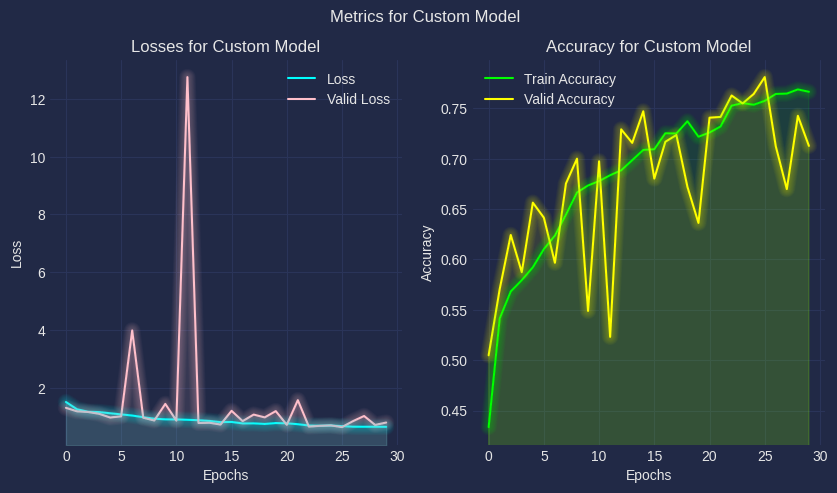

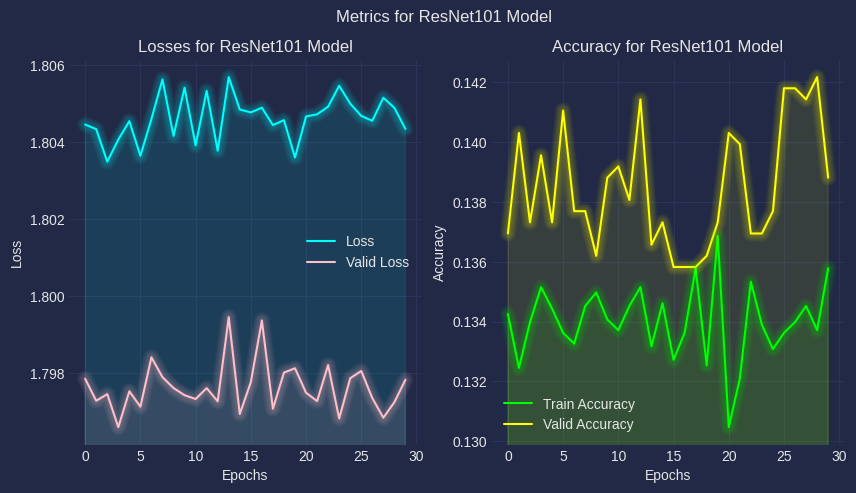

In [15]:
def plot_torch_metrics(hist, model, metric, colors):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f'Metrics for {model} Model')
    ax[0].set_title(f'Losses for {model} Model')
    ax[0].set_ylabel(f'Loss')
    ax[0].plot(hist['Train Loss'], color=colors[0], label='Loss')
    ax[0].plot(hist['Valid Loss'], color=colors[1], label='Valid Loss')
    
    ax[1].set_title(f'{metric.capitalize()} for {model} Model')
    ax[1].set_ylabel(f'{metric.capitalize()}')
    ax[1].plot(hist['Train ' + metric], color=colors[2], label='Train ' + metric.capitalize())
    ax[1].plot(hist['Valid '+ metric], color=colors[3], label='Valid ' + metric)

    for i in range(2):
        axes = ax[i]
        axes.set_xlabel('Epochs')
        axes.legend()
        mplcyberpunk.make_lines_glow(ax=axes)
        mplcyberpunk.add_underglow(ax=axes)

plot_torch_metrics(custom_model_metrics, 'Custom', 'Accuracy', ['cyan', 'pink', 'lime', 'yellow'])
plot_torch_metrics(resnet101_model_metrics, 'ResNet101', 'Accuracy', ['cyan', 'pink', 'lime', 'yellow'])

In [16]:
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs.data, dim=1)
            total_samples += labels.size(0)
            correct += (preds == labels).sum().item()

    eval_loss = total_loss / total_samples
    eval_acc = correct / total_samples

    return [eval_loss, float(eval_acc)]

eval_metrics = []
custom_model_eval = evaluate_model(custom_model, dls['test'], loss_fn, device)
resnet101_model_eval = evaluate_model(resnet101model, dls['test'], loss_fn, device)

for i in range(2):
    eval_metrics.append(custom_model_eval[i])
    eval_metrics.append(resnet101_model_eval[i])

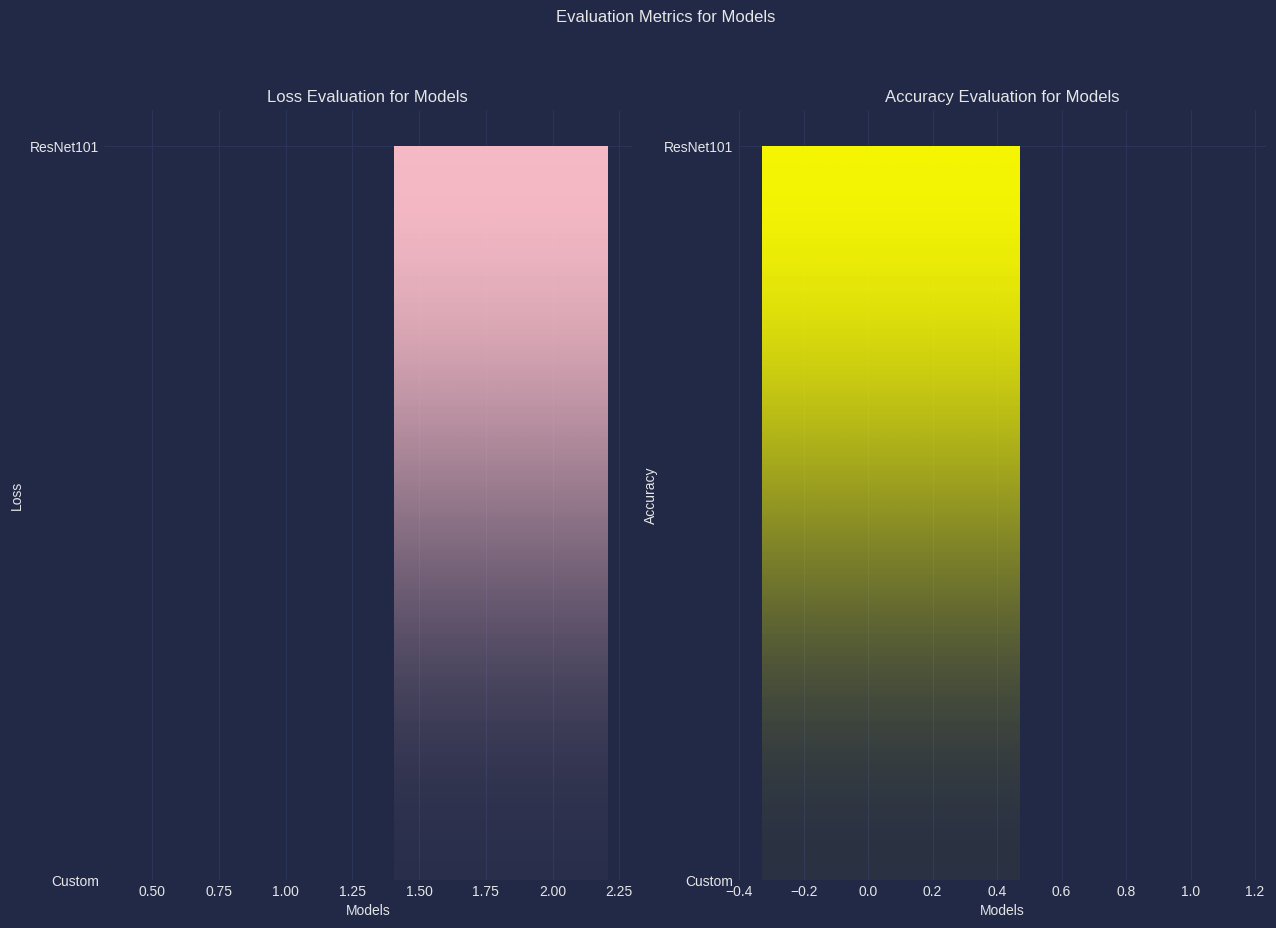

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
fig.suptitle('Evaluation Metrics for Models')

ax[0].set_title('Loss Evaluation for Models')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Loss')
loss_bar = ax[0].bar([eval_metrics[0], eval_metrics[1]], ['Custom', 'ResNet101'], color=['cyan', 'pink'])
mplcyberpunk.add_bar_gradient(loss_bar, ax=ax[0])

ax[1].set_title('Accuracy Evaluation for Models')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Accuracy')
acc_bar = ax[1].bar([eval_metrics[2], eval_metrics[3]], ['Custom', 'ResNet101'], color=['lime', 'yellow'])
mplcyberpunk.add_bar_gradient(acc_bar, ax=ax[1])

In [18]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, dim=1)
            all_preds.append(preds.tolist())
            all_labels.append(labels.tolist())
            all_images.append(images)

    return flatten(all_preds), flatten(all_images), flatten(all_labels)

cpreds, cimages, clabels = get_predictions(custom_model, dls['test'], device)
rpreds, rimages, rlabels = get_predictions(resnet101model, dls['test'], device)

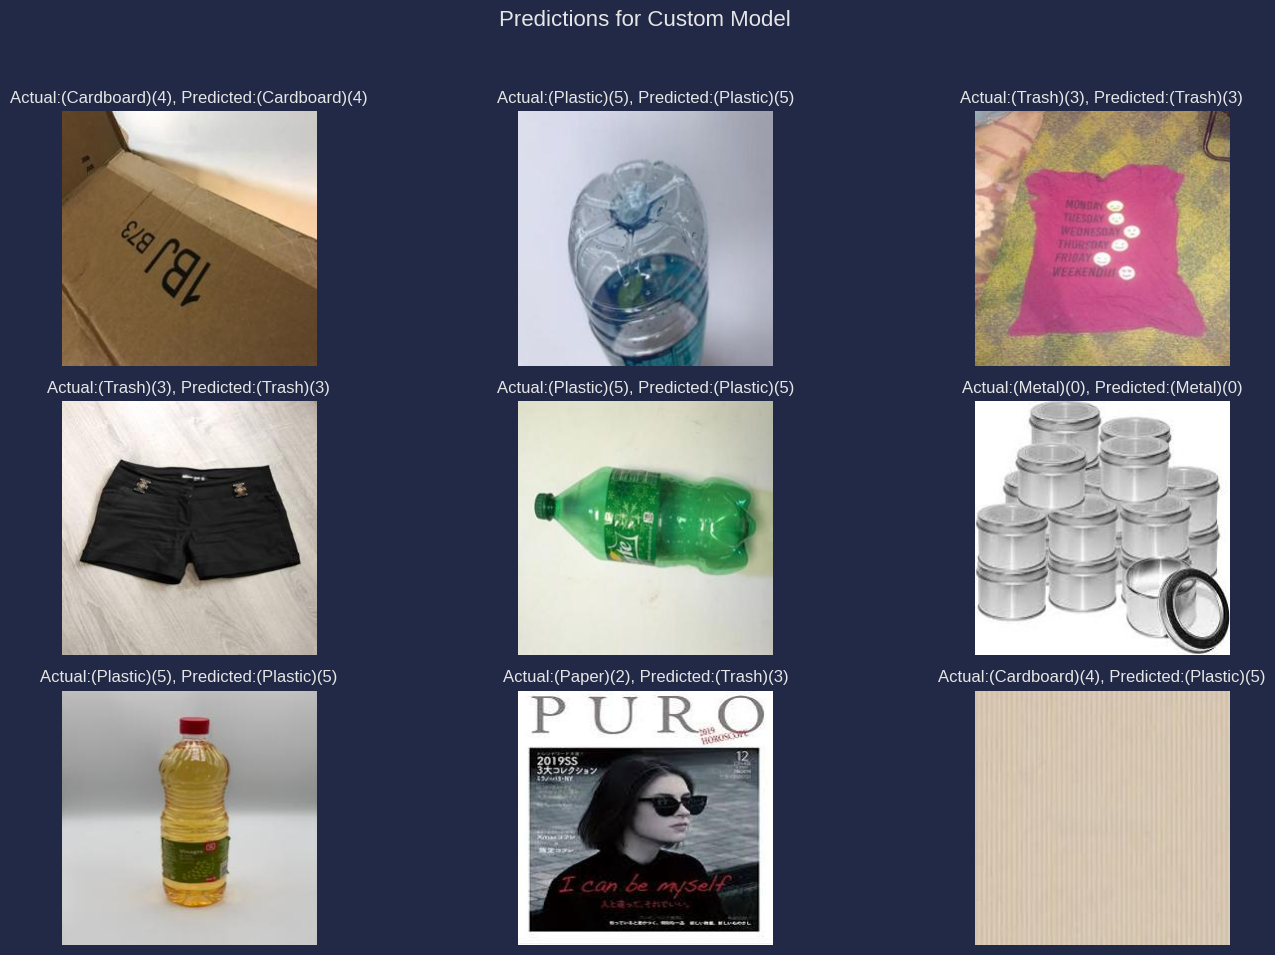

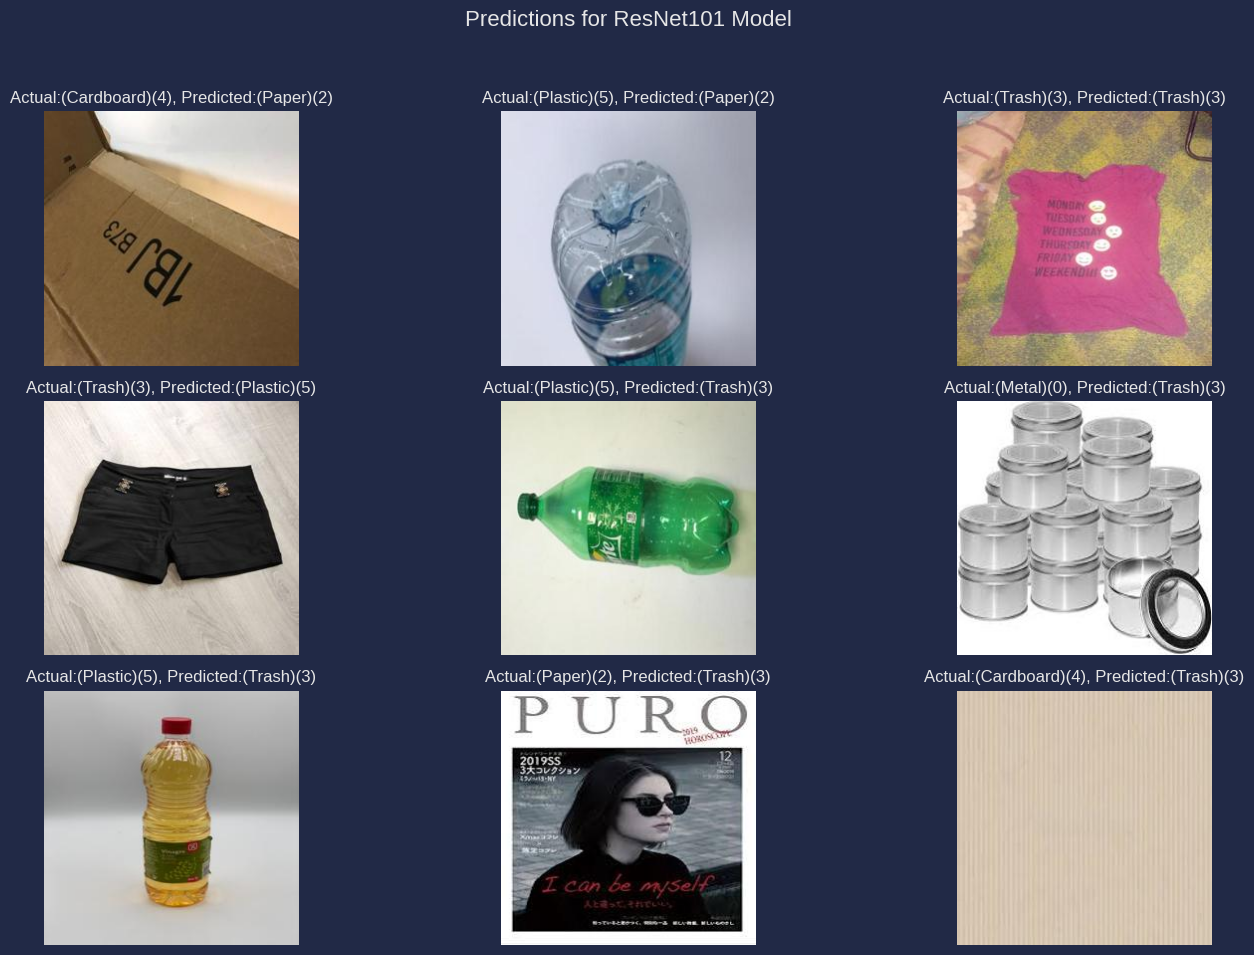

In [19]:
def plot_preds(model_name, preds, images, labels):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    fig.suptitle(f'Predictions for {model_name} Model', fontsize=16)
    ax = ax.flatten()
    to_pil = transforms.ToPILImage()
    
    for i in range(9):
        axes = ax[i]
        axes.set_title(f'Actual:({train_ds.idx_classes[labels[i]].capitalize()})({int(labels[i])}), Predicted:({train_ds.idx_classes[preds[i]].capitalize()})({int(preds[i])})')
        axes.imshow(to_pil(images[i]))
        axes.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_preds(model_name='Custom', preds=cpreds, images=cimages, labels=clabels)
plot_preds(model_name='ResNet101', preds=rpreds, images=rimages, labels=rlabels)